In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

In [73]:
data = pd.read_csv("./Datasets/Ethereum/ETH_USD.csv", skiprows=1, parse_dates=["Date"], index_col="Date")

data = data.drop(["Symbol","Unix Timestamp"] , axis=1)
data = data.sort_index()

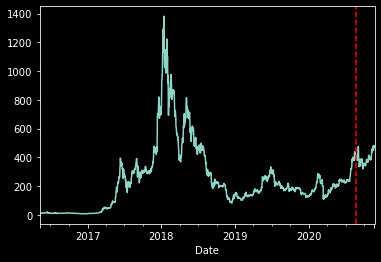

In [108]:
test_size = 90
cutoff = data.index.max() - datetime.timedelta(days=test_size)
data_tr, data_te = train_test_split(data["Close"], test_size=test_size, shuffle=False)

data["Close"].plot.line();
plt.axvline(x=cutoff, c="red", ls="--");

In [99]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        if i + n_steps > len(data) - 1:
            break
        else:
            seq_x, seq_y = data.iloc[i:i + n_steps], data.iloc[i + n_steps]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

tr_X, tr_y = split_sequence(data_tr, 30)

n_features = 1
tr_X = tr_X.reshape((tr_X.shape[0], tr_X.shape[1], n_features))

# Modeling

In [77]:
inputs = Input(shape=(n_steps, 1))

z = Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(n_steps, 1))(inputs) # (batch_size, 29, 64)
z = MaxPool1D(pool_size=2)(z) # (batch_size, 14, 64)
z = Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(n_steps, 1))(z) # (batch_size, 13, 128)
z = MaxPool1D(pool_size=2)(z) # (batch_size, 6, 128)
z = Conv1D(filters=256, kernel_size=2, activation="relu", input_shape=(n_steps, 1))(z) # (batch_size, 5, 256)
z = MaxPool1D(pool_size=2)(z) # (batch_size, 2, 256)
z = Flatten()(z) # (batch_size, 512)
z = Dense(units=128, activation="relu")(z) # (batch_size, 128)
z = Dropout(rate=0.5)(z)
z = Dense(units=64, activation="relu")(z) # (batch_size, 64)
z = Dropout(rate=0.5)(z)
z = Dense(units=32, activation="relu")(z) # (batch_size, 32)
z = Dropout(rate=0.5)(z)
outputs = Dense(units=1, activation="relu")(z) # (batch_size, 1)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="mae", metrics=["mae"])
# model.summary()

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
model_path = "eth_cnn.h5"
hist = model.fit(x=X, y=y, validation_split=0.2, shuffle=True, epochs=64, batch_size=64, callbacks=[es])

Epoch 1/64
20/20 [==============================] - 0s 13ms/step - loss: 156.4213 - mae: 156.4213 - val_loss: 94.8113 - val_mae: 94.8113
Epoch 2/64
20/20 [==============================] - 0s 8ms/step - loss: 117.4816 - mae: 117.4816 - val_loss: 67.8651 - val_mae: 67.8651
Epoch 3/64
20/20 [==============================] - 0s 7ms/step - loss: 113.4003 - mae: 113.4003 - val_loss: 93.1619 - val_mae: 93.1619
Epoch 4/64
20/20 [==============================] - 0s 8ms/step - loss: 105.0562 - mae: 105.0562 - val_loss: 85.6462 - val_mae: 85.6462
Epoch 5/64
20/20 [==============================] - 0s 7ms/step - loss: 97.6999 - mae: 97.6999 - val_loss: 65.0534 - val_mae: 65.0534
Epoch 6/64
20/20 [==============================] - 0s 7ms/step - loss: 97.7499 - mae: 97.7499 - val_loss: 64.4379 - val_mae: 64.4379
Epoch 7/64
20/20 [==============================] - 0s 7ms/step - loss: 96.4998 - mae: 96.4998 - val_loss: 65.9612 - val_mae: 65.9612
Epoch 8/64
20/20 [==============================] - 0

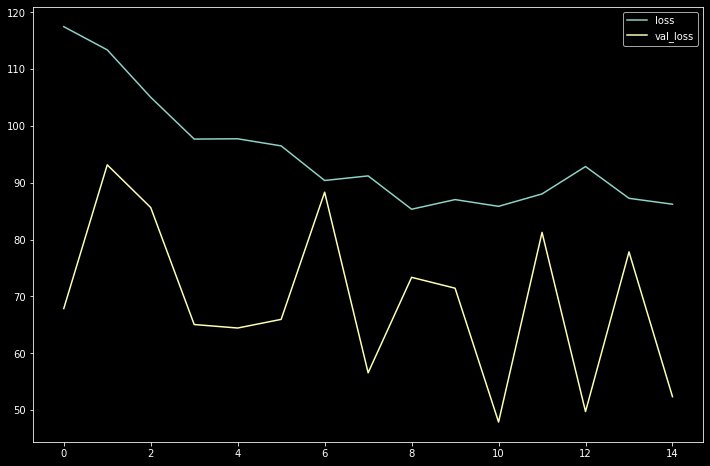

In [78]:
fig, axes = plt.subplots(figsize=(12, 8))
axes.plot(hist.history["loss"][1:], label="loss");
axes.plot(hist.history["val_loss"][1:], label="val_loss");
axes.legend();

In [87]:
data_tr_pred = data_tr.to_frame()[n_steps:]
tr_preds = model.predict(tr_X)
data_tr_pred["pred"] = tr_preds

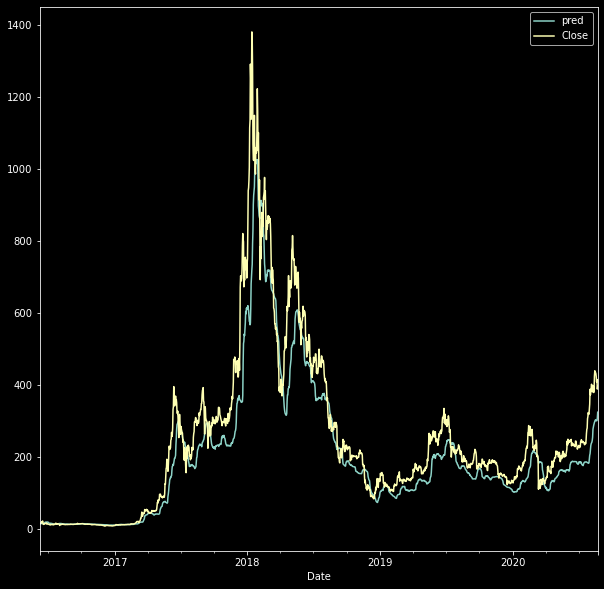

In [90]:
# Lagging = 예측값이 실제 값보다 N 스텝 앞에 있는 경우
# Forwarding = 예측값이 실제 값보다 N 스텝 뒤에 있는 경우
fig, ax = plt.subplots(figsize=(10, 10))
data_tr_pred["pred"].plot(ax=ax, legend=True);
data_tr_pred["Close"].plot(ax=ax, legend=True);

In [110]:
test_raw_seq = data_te

test_X, test_y = split_sequence(test_raw_seq, n_steps)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

y_pred = model.predict(test_X)

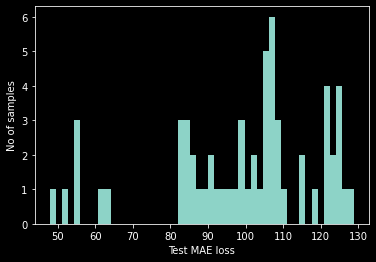

In [114]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [115]:
data_te_pred = data_te.to_frame()[n_steps:]
data_te_pred['pred'] = y_pred

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
data_te_pred['pred'].plot(ax=ax, legend=True)
data_te_pred['Close'].plot(ax=ax, legend=True)

# Modeling Multi Step

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
raw_seq = data_tr

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
X.shape

In [ ]:
model = keras.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
# 모델을 추가. (Seq2seq, Encoder-Decoder)
# 내가 출력할 시계열에 어떤 특징이 없을때
model.add(layers.Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
# model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X, y, epochs=100)

In [ ]:
tr_preds = model.predict(X)

train_mae_loss = np.mean(np.abs(tr_preds - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
tr_preds.shape

In [ ]:
for i, pred in enumerate(tr_preds[:5]):
  data_tr_pred = data_tr[i:i+n_steps_out]
  data_tr_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  data_te_pred['pred'].plot(ax=ax, legend=True)
  data_te_pred['Close'].plot(ax=ax, legend=True)
  plt.show()

In [ ]:
# TODO: TEST에 대해서도 똑같은 검증을 해보세요.